# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.generator import get_revenue_behaviour_old

schedule = {'1': {'Madrid': [1055, 1055], 'Lleida': [1150, 1150]},
            '2': {'Madrid': [1080, 1080], 'Calatayud': [1130, 1134], 'Lleida': [1210, 1214],
                  'Barcelona': [1280, 1280]},
            '3': {'Zaragoza': [1210, 1210], 'Barcelona': [1283, 1283]}}

"""
schedule = {'1': {'Madrid': [872.0, 872.0], 
                                   'Zaragoza': [969.0, 970.0],
                                   'Tarragona': [1042.0, 1044.0],
                                   'Barcelona': [1094.0, 1094.0]}, 
            '10': {'Madrid': [748.0, 748.0],
                    'Barcelona': [923.0, 923.0]}}
"""
line_stations = {'Madrid': (40.406442, -3.690886),
                 'Calatayud': (41.346692, -1.63868),
                 'Zaragoza': (41.658649, -0.911615),
                 'Lleida': (41.620696, 0.632669),
                 'Tarragona': (41.111624, 1.253214),
                 'Barcelona': (41.37922, 2.140624)}

revenue = get_revenue_behaviour_old(schedule)

sm = RevenueMaximization(requested_schedule=schedule,
                         revenue_behaviour=revenue,
                         line=line_stations)

print(sm.conflict_matrix)

[[False False False]
 [False False  True]
 [False  True False]]


In [25]:
sm.operational_times

{'1': [95], '2': [73], '3': [50, 4, 76, 4, 66]}

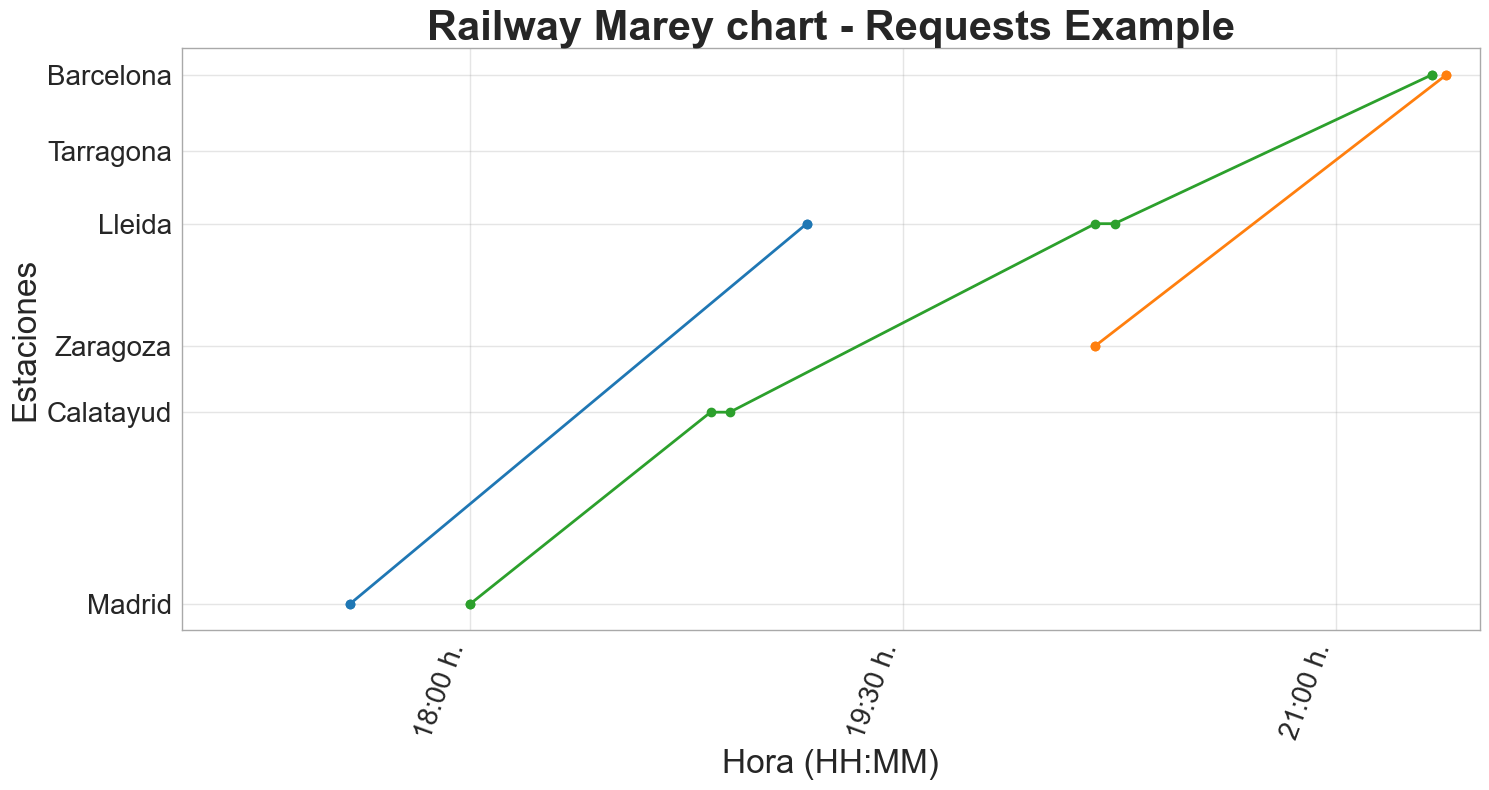

In [26]:
from benchmarks.utils import TrainSchedulePlotter

schedule_plotter = TrainSchedulePlotter(schedule, line_stations)
schedule_plotter.plot(main_title=f"Railway Marey chart - Requests Example",
                      save_path='../figures/example.pdf')

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


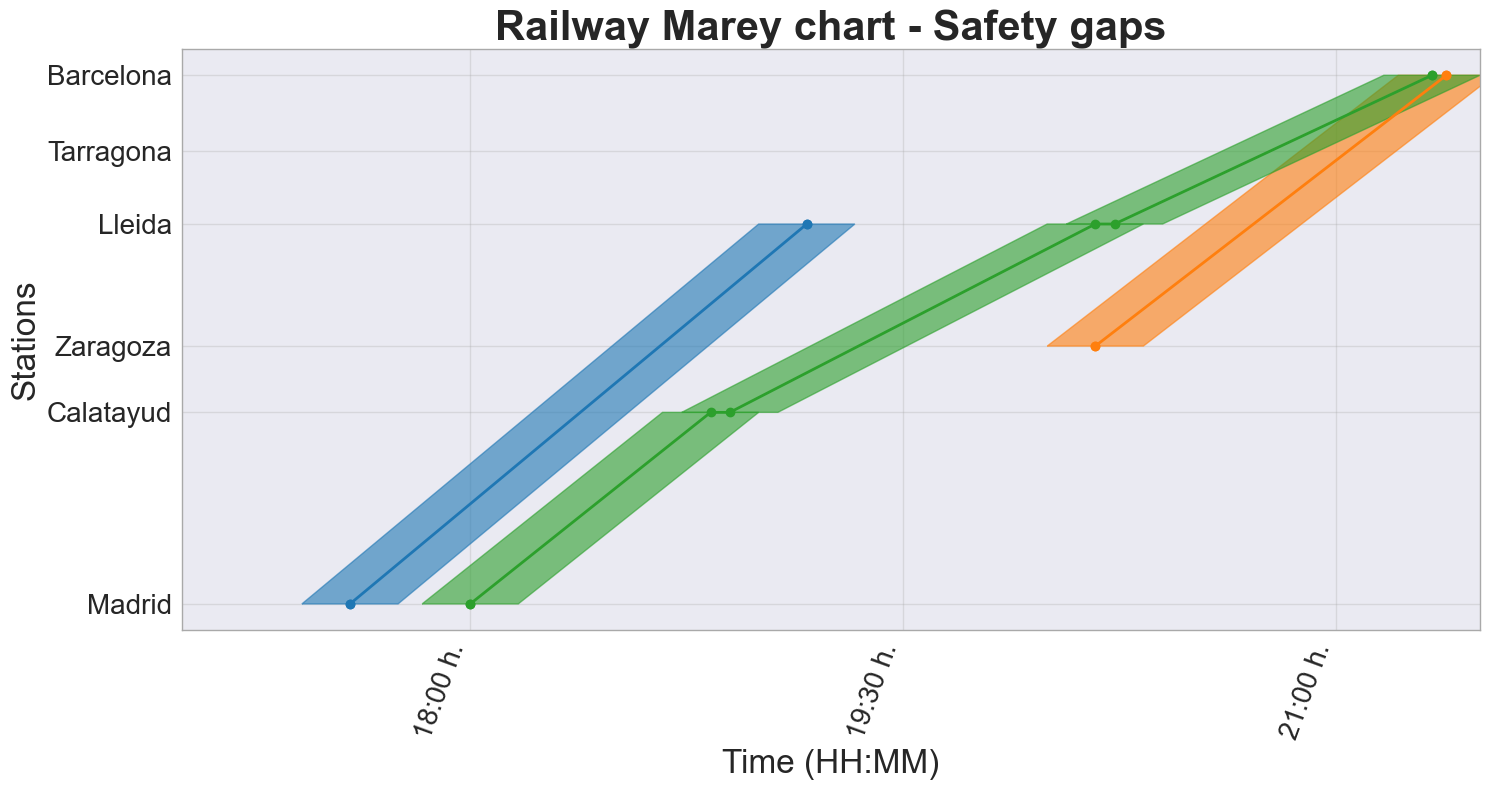

In [113]:
security_gap = 10
schedule_plotter.plot(main_title=f"Railway Marey chart - Safety gaps",
                      plot_security_gaps=True,
                      security_gap=security_gap,
                      save_path='../figures/example_security_gaps.pdf')

In [106]:
from src.entities import GSA

gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               custom_repair=sm.custom_repair,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [107]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

#gsa_algo.set_seed()

pop_size = 30

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=50,
                                     chaotic_constant=True,
                                     repair_solution=True,
                                     initial_population=sm.get_initial_population(pop_size),
                                     verbose=True)
pr.disable()
print(f"Elapsed time: {round(time.time() - start, 2)} seconds")

pr.dump_stats('profile.pstat')

GSA is optimizing  "get_fitness_gsa"
['At iteration 1 the best fitness is 2091.583613277351']
['At iteration 2 the best fitness is 2355.9722079843727']
['At iteration 3 the best fitness is 2355.9722079843727']
['At iteration 4 the best fitness is 2355.9722079843727']
['At iteration 5 the best fitness is 2355.9722079843727']
['At iteration 6 the best fitness is 2355.9722079843727']
['At iteration 7 the best fitness is 2355.9722079843727']
['At iteration 8 the best fitness is 2355.9722079843727']
['At iteration 9 the best fitness is 2365.8344928972356']
['At iteration 10 the best fitness is 2375.0446777032816']
['At iteration 11 the best fitness is 2375.0446777032816']
['At iteration 12 the best fitness is 2375.0446777032816']
['At iteration 13 the best fitness is 2375.0446777032816']
['At iteration 14 the best fitness is 2375.0446777032816']
['At iteration 15 the best fitness is 2375.0446777032816']
['At iteration 16 the best fitness is 2375.0446777032816']
['At iteration 17 the best fi

In [108]:
revenue

{'1': {'canon': 830.0,
  'k': 1.01,
  'dt_max_penalty': 116.2,
  'tt_max_penalty': 215.8},
 '2': {'canon': 830.0,
  'k': 1.02,
  'dt_max_penalty': 116.2,
  'tt_max_penalty': 215.8},
 '3': {'canon': 1660.0,
  'k': 1.01,
  'dt_max_penalty': 232.4,
  'tt_max_penalty': 143.87}}

In [109]:
sm.best_solution.real, sm.best_solution.discrete

(array([1051, 1219, 1080, 1134, 1214]), array([False,  True,  True]))

In [ ]:
sm.update_schedule(solution=sm.best_solution)

schedule_plotter = TrainSchedulePlotter(sm.updated_schedule, line_stations)
security_gap = 10
schedule_plotter.plot(main_title=f"Railway Marey chart - Safety gaps (Solution)",
                      plot_security_gaps=True,
                      security_gap=security_gap,
                      save_path='../figures/example_security_gaps.pdf')

In [110]:
sm.conflict_matrix

array([[False, False,  True],
       [False, False, False],
       [ True, False, False]])

In [41]:
sm.get_revenue(sm.best_solution)

987.7

In [42]:
sm.is_feasible(sm.best_solution, sm.best_solution.discrete)

True

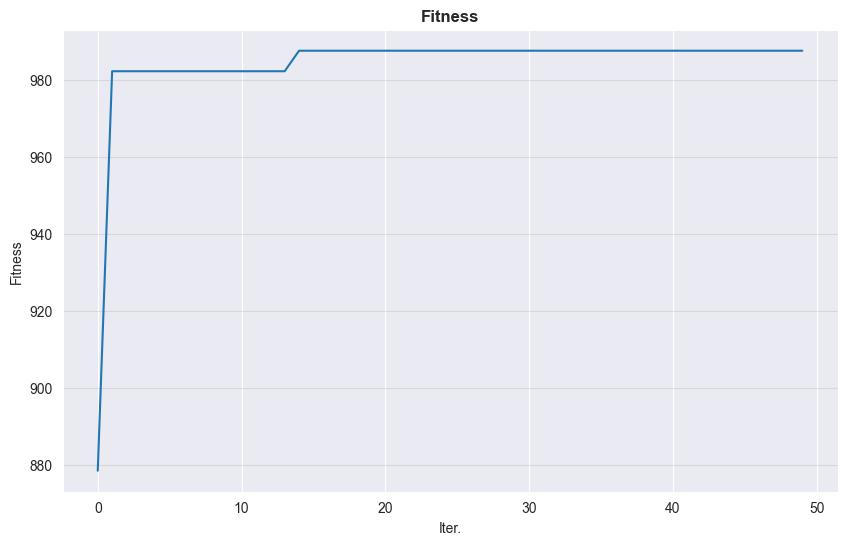

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [44]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [13]:
sum([sm.revenue[service]['canon'] for service in sm.revenue])

643.5

In [14]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,624.376168,0,0.005983,[],"[1250, 819, 1222, 1174, 958]"
1,1,624.376168,0,0.016689,[],"[1250, 819, 1222, 1174, 958]"
2,2,625.914299,0,0.027098,[],"[1249.0, 818.0, 1229.0, 1178.0, 960.0]"
3,3,625.914299,0,0.035553,[],"[1249.0, 818.0, 1229.0, 1178.0, 960.0]"
4,4,637.798558,0,0.043507,[],"[1247.0, 820.0, 1224.0, 1176.0, 962.0]"
...,...,...,...,...,...,...
95,95,643.500000,0,0.635287,[],"[1248.0, 821.0, 1224.0, 1177.0, 960.0]"
96,96,643.500000,0,0.639542,[],"[1248.0, 821.0, 1224.0, 1177.0, 960.0]"
97,97,643.500000,0,0.643556,[],"[1248.0, 821.0, 1224.0, 1177.0, 960.0]"
98,98,643.500000,0,0.647989,[],"[1248.0, 821.0, 1224.0, 1177.0, 960.0]"


In [16]:
from robin.scraping.entities import SupplySaver

supply_save_path = '../configs/gsa_results/'

if not Path(supply_save_path).exists():
    Path(supply_save_path).mkdir(parents=True)
    
SupplySaver(services).to_yaml(filename='supply.yml', save_path='../configs/gsa_results/')

In [18]:
from robin.kernel.entities import Kernel

path_config_supply = '../configs/gsa_results/supply.yml'
path_config_demand = '../configs/demand/demand.yml'
path_output_csv = '../data/output/robin/output.csv'

if not Path(path_output_csv).parent.exists():
    Path(path_output_csv).parent.mkdir(parents=True)
    
seed = 0

kernel = Kernel(path_config_supply, path_config_demand, seed)
services = kernel.simulate(output_path=path_output_csv, departure_time_hard_restriction=True)

In [20]:
import pandas as pd

df = pd.read_csv(path_output_csv)
df

,id,user_pattern,departure_station,arrival_station,arrival_day,arrival_time,purchase_day,service,service_departure_time,service_arrival_time,seat,price,utility,best_service,best_seat,best_utility
0,42,Tourist,60000,4040,2023-06-25,9.731107,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,Tourist,60000,4040,2023-06-25,6.104585,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,Tourist,60000,4040,2023-06-25,19.097141,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87,Tourist,60000,4040,2023-06-25,7.306265,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112,Tourist,60000,4040,2023-06-25,11.312883,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9205,8869,Student,60000,71801,2023-06-25,18.642302,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875
9206,8962,Student,60000,71801,2023-06-25,17.055001,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875
9207,9051,Student,60000,71801,2023-06-25,18.623643,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875
9208,9177,Student,60000,71801,2023-06-25,21.304901,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875


In [22]:
from robin.supply.entities import Supply

supply = Supply.from_yaml(path_config_supply)

services_tsp = {service.id: service.tsp.name for service in supply.services}

In [25]:
import numpy as np

df['tsp'] = df['service'].apply(lambda service_id: services_tsp.get(service_id, np.NaN))
df

,id,user_pattern,departure_station,arrival_station,arrival_day,arrival_time,purchase_day,service,service_departure_time,service_arrival_time,seat,price,utility,best_service,best_seat,best_utility,tsp
0,42,Tourist,60000,4040,2023-06-25,9.731107,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,Tourist,60000,4040,2023-06-25,6.104585,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,Tourist,60000,4040,2023-06-25,19.097141,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87,Tourist,60000,4040,2023-06-25,7.306265,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112,Tourist,60000,4040,2023-06-25,11.312883,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9205,8869,Student,60000,71801,2023-06-25,18.642302,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875,NaN
9206,8962,Student,60000,71801,2023-06-25,17.055001,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875,NaN
9207,9051,Student,60000,71801,2023-06-25,18.623643,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875,NaN
9208,9177,Student,60000,71801,2023-06-25,21.304901,0,NaN,NaN,NaN,NaN,NaN,NaN,03612_2024-06-25-16.00,Turista,25.461875,NaN


In [29]:
tsp_revenue = df.groupby('tsp').agg({'price': 'sum'}).to_dict()['price']
tsp_revenue

{'IRYO': 36001.5, 'Renfe AVE': 34742.0}